# Transform data from WormND .h5 and Stardist segmentation to file format after preprocessing by Atanas et al. (2024)
- goal: create ROI, image, and labels files according to registration logic (in pairs of 2; moving and fixed)
- next step: run centroid code from BrainAlignnet? otherwise make own centroids, difficulty is making sure the format is the same as expected from BrainAlignNet


In [1]:
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import json
import os


dataset='EY'

pre_path = '/scratch/nar8991/computer_vision/data' #wherever you have saved the h5 worm files
if dataset=='EY':
    filename = f"{pre_path}/EY_raw/sub-20190925-04_ses-20190925_ophys.h5"
    filename2 = f"{pre_path}/EY_raw/sub-20190925-04_ses-20190925_ophys_stardist.npy"
elif dataset=='KK':
    filename = f"{pre_path}/KK/sub-230928-02_ses-20230928T111400_ophys.h5"
elif dataset=='SK1':
    filename = f"{pre_path}/SK1/sub-20230322-18-57-04_ses-20230322T185704_ophys.h5"
elif dataset=='SK2':
    filename = f"{pre_path}/SK2/sub-2022-04-26-w01-NP1_ses-20220426_ophys.h5"
    
h5 = h5py.File(filename,'r')
target_labels =  np.array(h5["calcium_segmentation"])
image_data = np.array(h5["calcium_image"])

seg = np.load(filename2)

os.makedirs(f'{pre_path}/{dataset}/train',exist_ok=True)
os.makedirs(f'{pre_path}/{dataset}/valid',exist_ok=True)
os.makedirs(f'{pre_path}/{dataset}/test',exist_ok=True)

In [3]:
#load data from atanas (2024) for format
pre_path = '/scratch/nar8991/computer_vision/data/Atanas_processed/valid/nonaugmented'
img_at = h5py.File(f"{pre_path}/fixed_images.h5")
labels_at = h5py.File(f"{pre_path}/fixed_labels.h5")
rois_at = h5py.File(f"{pre_path}/fixed_rois.h5")


with open(f'/scratch/nar8991/computer_vision/BrainAlignNet/scripts/data_preparation/resources/registration_problems.json', 'r') as file:
    reg_at = json.load(file)


## Make registration_problems.json

In [4]:
new_reg={'train':{},'valid':{},'test':{},}

# loop over worms here once we have >1
new_reg['train']['EY/sub-20190925-04_ses-20190925']=[]
T = image_data.shape[0]
N_pairs=50

# Up this so we get more pairs
match_idxs=np.random.choice(np.arange(T), size=(N_pairs,2), replace=False) #replace=true, just make sure that the same neuron is not in one row twice??

for i,row in enumerate(match_idxs):
    new_reg['train']['EY/sub-20190925-04_ses-20190925'].append(f"{row[0]}to{row[1]}")

new_reg['valid']=new_reg['train']
new_reg['test']=new_reg['train']

new_reg_path = '/scratch/nar8991/computer_vision/BrainAlignNet/scripts/data_preparation/resources/registration_problems_ey.json'
with open(new_reg_path, 'w') as f:
    json.dump(new_reg, f)

In [5]:
with open(new_reg_path, 'r') as file:
    reg_ours = json.load(file)

#their file:
print(reg_at.keys())
print(reg_at)
for worm in reg_at['train']:
    print(len(reg_at['train'][worm]))
    print(reg_at['train'][worm])
    break
    #about N= 80-100 samples per worm
    #per worm: list of N strings with time <t_moving>to<t_fixed>

#our file:
print('\n')
print(reg_ours.keys())
print(reg_ours)
for worm in reg_ours['train']:
    print(len(reg_ours['train'][worm]))
    print(reg_ours['train'][worm])
    break


dict_keys(['train', 'valid', 'test'])
{'train': {'2022-01-17-01': ['1002to1197', '1015to1127', '1025to1514', '103to642', '108to1357', '1124to1347', '116to740', '11to719', '1213to1522', '1215to1229', '1270to1455', '1276to1510', '1290to1311', '1290to1391', '1292to1328', '1320to1586', '1336to1455', '1372to1465', '1391to1404', '141to1358', '158to535', '167to983', '175to555', '18to605', '198to1183', '199to1565', '19to517', '209to455', '222to1408', '230to866', '241to1502', '266to509', '266to844', '273to770', '274to995', '298to1579', '304to933', '319to1097', '330to1585', '332to1558', '355to740', '371to682', '374to950', '385to672', '404to660', '406to997', '412to643', '415to1189', '419to1333', '449to1563', '44to824', '483to754', '493to1397', '500to933', '50to276', '516to1018', '517to1119', '521to712', '530to614', '533to895', '548to1066', '548to1241', '549to840', '54to891', '558to1082', '564to567', '569to775', '580to713', '584to1052', '592to1279', '598to690', '619to1329', '62to336', '631to851', 

## Make fixed_images.h5 and moving_images.h5

In [8]:
print(np.array(img_at['601to907']).shape) #(284, 120, 64), rois only for first part of string -> 1037 (for fixed_rois)
#-> contains labels for 200 cells (at this point)

plt.imshow(np.array(img_at['601to907'])[:,:,40])

KeyError: "Unable to synchronously open object (object '601to907' doesn't exist)"

In [ ]:
mode='train'
#loop over train and test splits here (should be different folders for train/test/val images)
file_path = '/scratch/nar8991/computer_vision/data/EY_correct'

path_fixed = f'{file_path}/{mode}/fixed_images.h5'
path_moving = f'{file_path}/{mode}/moving_images.h5'
f_fixed= h5py.File(path_fixed, 'w')
f_moving= h5py.File(path_moving, 'w')

#loop over worms -> for images label here (image_data)

for worm in reg_ours[mode]:
    print(reg_ours[mode][worm])
    for reg_problem in reg_ours[mode][worm]:
        mov,fix=np.array(reg_problem.split("to")).astype(int)
        moving_img = image_data[mov,:,:,:]
        fixed_img = image_data[fix,:,:,:]

        #write images to moving_images.h5 and fixed_images.h5
        f_fixed.create_dataset(reg_problem, data=fixed_img)
        f_moving.create_dataset(reg_problem, data=moving_img)

f_fixed.close()
f_moving.close()
        

['429to62', '586to8', '631to296', '75to387', '804to785', '760to907', '280to916', '891to892', '95to889', '910to272', '49to464', '666to824', '670to301', '388to615', '70to868', '442to481', '221to403', '694to513', '378to664', '789to149', '3to264', '107to593', '187to194', '208to637', '515to307', '577to752', '572to465', '716to809', '271to260', '742to749', '467to837', '468to771', '418to911', '282to40', '435to419', '170to279', '923to711', '163to841', '657to448', '470to460', '836to876', '704to574', '118to229', '58to819', '87to823', '128to184', '285to248', '267to224', '399to906', '227to129']


## Make fixed_roi.h5 and moving_roi.h5

(284, 120, 64)
0.0
150.0


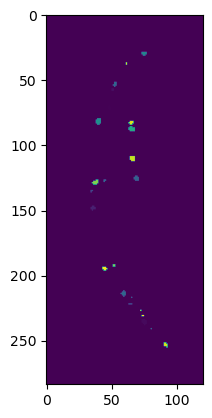

In [43]:
print(np.array(rois_at['1037to1125']).shape) #(284, 120, 64), rois only for first part of string -> 1037 (for fixed_rois)
print(np.array(rois_at['1037to1125']).min()) #0.0
print(np.array(rois_at['1037to1125']).max()) #150.0
#-> contains segmentation (whole, not just centroids)

plt.imshow(np.array(rois_at['1037to1125'])[:,:,40])

In [44]:
mode='train'
pre_path='data_our' #path to segmentation output
#loop over train and test splits here (should be different folders for train/test/val images)

path_fixed = f'data/{mode}/fixed_rois.h5'
path_moving = f'data/{mode}/moving_rois.h5'
f_fixed= h5py.File(path_fixed, 'w')
f_moving= h5py.File(path_moving, 'w')

for worm in reg_ours[mode]:
    seg=np.load(f"{pre_path}/{worm}_ophys_stardist.npy") #load stardist segmentation output
    for reg_problem in reg_ours[mode][worm]:
        

        mov,fix=np.array(reg_problem.split("to")).astype(int)
        #transforming output to get from shape (21, 128, 256) to (256, 128, 21) should probably be-> same shape as for image files)
        moving_roi = seg[mov,:,:,:].T
        fixed_roi = seg[fix,:,:,:].T

        #write images to moving_images.h5 and fixed_images.h5
        f_fixed.create_dataset(reg_problem, data=fixed_roi)
        f_moving.create_dataset(reg_problem, data=moving_roi)

f_fixed.close()
f_moving.close()
        

## Make fixed_labels.h5 and moving_labels.h5

(200, 3)


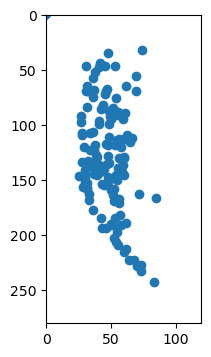

In [45]:
print(np.array(labels_at['1037to1125']).shape) #(200,3), rois only for first part of string -> 1037 (for fixed_rois)
#-> contains labels for 200 cells (at this point)

plt.figure(figsize=(2,4))
plt.scatter(np.array(labels_at['1037to1125'])[:,1],np.array(labels_at['1037to1125'])[:,0])
plt.xlim(0,120)
plt.ylim(0,280)
plt.gca().invert_yaxis()


In [46]:
mode='train'

#loop over train and test splits here (should be different folders for train/test/val images)


path_fixed = f'data/{mode}/fixed_labels.h5'
path_moving = f'data/{mode}/moving_labels.h5'
f_fixed= h5py.File(path_fixed, 'w')
f_moving= h5py.File(path_moving, 'w')

#loop over worms -> for target label here (target_labels)

for worm in reg_ours[mode]:

    for reg_problem in reg_ours[mode][worm]:
        
        mov,fix=np.array(reg_problem.split("to")).astype(int)
        #transforming output to get from shape (21, 128, 256) to (256, 128, 21) should probably be-> same shape as for image files)
        moving_l = target_labels[mov,:,:]
        fixed_l = target_labels[fix,:,:]

        #write images to moving_images.h5 and fixed_images.h5
        f_fixed.create_dataset(reg_problem, data=fixed_l)
        f_moving.create_dataset(reg_problem, data=moving_l)

f_fixed.close()
f_moving.close()
        

Padding steps

In [ ]:
# Apply padding to the h5 files


In [ ]:
# Adjust the dat